# Can we predict which presidential candidate a county voted for in the 2000 general election based on Census Demographic data?

We are using two datasets, the first comes from Harvard's Dataverse (https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/VOQCHQ) and it provides county level data for the election. It specifies how many votes were cast and how many votes within that number of total votes cast went to each presidential candidate. The second dataset comes from the US Cesnsus Bureau (https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?src=bkmk). It proveds county level demographic data. We will need to combine some of the columns into a new table to get started.

In [710]:
## load the libraries

import pandas as pd
import numpy as np
import csv
import urllib
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [711]:
## import data

urldemographics = 'https://raw.githubusercontent.com/TimSrenaski/DATA201_Voter_Prediction/master/DEC_00_SF1_QTH1.csv'
urlVoteRecord = 'https://raw.githubusercontent.com/TimSrenaski/DATA201_Voter_Prediction/master/countypres_2000-2016.csv'

rawdemographics = pd.read_csv(urldemographics, sep=',', encoding = 'latin-1')
rawVotes = pd.read_csv(urlVoteRecord, sep=',', encoding = 'latin-1')

## Clean the vote record dataframe

In [712]:
rawVotes.head()

,year,state,state_po,county,FIPS,office,candidate,party,candidatevotes,totalvotes,version
0,2000,Alabama,AL,Autauga,1001.0,President,Al Gore,democrat,4942.0,17208.0,20181011
1,2000,Alabama,AL,Autauga,1001.0,President,George W. Bush,republican,11993.0,17208.0,20181011
2,2000,Alabama,AL,Autauga,1001.0,President,Ralph Nader,green,160.0,17208.0,20181011
3,2000,Alabama,AL,Autauga,1001.0,President,Other,NaN,113.0,17208.0,20181011
4,2000,Alabama,AL,Baldwin,1003.0,President,Al Gore,democrat,13997.0,56480.0,20181011


In [713]:
rawVotes.dtypes

year                int64
state              object
state_po           object
county             object
FIPS              float64
office             object
candidate          object
party              object
candidatevotes    float64
totalvotes        float64
version             int64
dtype: object

In [714]:
rawVotes.shape

(50528, 11)

In [715]:
## limit the voter data to just year 2000 results

is_2000 = rawVotes['year']==2000
print(is_2000.head())

0    True
1    True
2    True
3    True
4    True
Name: year, dtype: bool


In [716]:
## filter rows for 2000 using boolean variables

votes_2000 = rawVotes[is_2000]

In [717]:
votes_2000.shape

(12632, 11)

In [718]:
votes_2000

,year,state,state_po,county,FIPS,office,candidate,party,candidatevotes,totalvotes,version
0,2000,Alabama,AL,Autauga,1001.0,President,Al Gore,democrat,4942.0,17208.0,20181011
1,2000,Alabama,AL,Autauga,1001.0,President,George W. Bush,republican,11993.0,17208.0,20181011
2,2000,Alabama,AL,Autauga,1001.0,President,Ralph Nader,green,160.0,17208.0,20181011
3,2000,Alabama,AL,Autauga,1001.0,President,Other,NaN,113.0,17208.0,20181011
4,2000,Alabama,AL,Baldwin,1003.0,President,Al Gore,democrat,13997.0,56480.0,20181011
5,2000,Alabama,AL,Baldwin,1003.0,President,George W. Bush,republican,40872.0,56480.0,20181011
6,2000,Alabama,AL,Baldwin,1003.0,President,Ralph Nader,green,1033.0,56480.0,20181011
7,2000,Alabama,AL,Baldwin,1003.0,President,Other,NaN,578.0,56480.0,20181011
8,2000,Alabama,AL,Barbour,1005.0,President,Al Gore,democrat,5188.0,10395.0,20181011
9,2000,Alabama,AL,Barbour,1005.0,President,George W. Bush,republican,5096.0,10395.0,20181011


In [719]:
idx = votes_2000.groupby(['county', 'state'])['candidatevotes'].transform(max) == votes_2000['candidatevotes']

winners = votes_2000[idx]

In [720]:
winners

,year,state,state_po,county,FIPS,office,candidate,party,candidatevotes,totalvotes,version
1,2000,Alabama,AL,Autauga,1001.0,President,George W. Bush,republican,11993.0,17208.0,20181011
5,2000,Alabama,AL,Baldwin,1003.0,President,George W. Bush,republican,40872.0,56480.0,20181011
8,2000,Alabama,AL,Barbour,1005.0,President,Al Gore,democrat,5188.0,10395.0,20181011
13,2000,Alabama,AL,Bibb,1007.0,President,George W. Bush,republican,4273.0,7101.0,20181011
17,2000,Alabama,AL,Blount,1009.0,President,George W. Bush,republican,12667.0,17973.0,20181011
20,2000,Alabama,AL,Bullock,1011.0,President,Al Gore,democrat,3395.0,4904.0,20181011
25,2000,Alabama,AL,Butler,1013.0,President,George W. Bush,republican,4127.0,7803.0,20181011
29,2000,Alabama,AL,Calhoun,1015.0,President,George W. Bush,republican,22306.0,38909.0,20181011
33,2000,Alabama,AL,Chambers,1017.0,President,George W. Bush,republican,6037.0,11834.0,20181011
37,2000,Alabama,AL,Cherokee,1019.0,President,George W. Bush,republican,4154.0,7823.0,20181011


## Clean the demographics dataframe

In [721]:
rawdemographics.head()

,GEO.id,GEO.id2,GEO.display-label,HC01_VC02,HC02_VC02,HC01_VC03,HC02_VC03,HC01_VC04,HC02_VC04,HC01_VC06,...,HC01_VC38,HC02_VC38,HC01_VC39,HC02_VC39,HC01_VC40,HC02_VC40,HC01_VC41,HC02_VC41,HC01_VC42,HC02_VC42
0,Id,Id2,Geography,Number; OCCUPANCY STATUS - Total housing units,Percent; OCCUPANCY STATUS - Total housing units,Number; OCCUPANCY STATUS - Total housing units...,Percent; OCCUPANCY STATUS - Total housing unit...,Number; OCCUPANCY STATUS - Total housing units...,Percent; OCCUPANCY STATUS - Total housing unit...,Number; TENURE - Occupied housing units,...,Number; AGE OF HOUSEHOLDER - Occupied housing ...,Percent; AGE OF HOUSEHOLDER - Occupied housing...,Number; AGE OF HOUSEHOLDER - Occupied housing ...,Percent; AGE OF HOUSEHOLDER - Occupied housing...,Number; AGE OF HOUSEHOLDER - Occupied housing ...,Percent; AGE OF HOUSEHOLDER - Occupied housing...,Number; AGE OF HOUSEHOLDER - Occupied housing ...,Percent; AGE OF HOUSEHOLDER - Occupied housing...,Number; AGE OF HOUSEHOLDER - Occupied housing ...,Percent; AGE OF HOUSEHOLDER - Occupied housing...
1,0500000US01001,1001,"Autauga County, Alabama",17662,100,16003,90.6,1659,9.4,16003,...,2494,15.6,2974,18.6,1771,11.1,951,5.9,252,1.6
2,0500000US01003,1003,"Baldwin County, Alabama",74285,100,55336,74.5,18949,25.5,55336,...,8831,16,13928,25.2,7850,14.2,4791,8.7,1287,2.3
3,0500000US01005,1005,"Barbour County, Alabama",12461,100,10409,83.5,2052,16.5,10409,...,1507,14.5,2636,25.3,1388,13.3,923,8.9,325,3.1
4,0500000US01007,1007,"Bibb County, Alabama",8345,100,7421,88.9,924,11.1,7421,...,1148,15.5,1620,21.8,896,12.1,543,7.3,181,2.4


In [722]:
rawdemographics.dtypes

GEO.id               object
GEO.id2              object
GEO.display-label    object
HC01_VC02            object
HC02_VC02            object
HC01_VC03            object
HC02_VC03            object
HC01_VC04            object
HC02_VC04            object
HC01_VC06            object
HC02_VC06            object
HC01_VC07            object
HC02_VC07            object
HC01_VC08            object
HC02_VC08            object
HC01_VC10            object
HC02_VC10            object
HC01_VC11            object
HC02_VC11            object
HC01_VC12            object
HC02_VC12            object
HC01_VC13            object
HC02_VC13            object
HC01_VC14            object
HC02_VC14            object
HC01_VC15            object
HC02_VC15            object
HC01_VC16            object
HC02_VC16            object
HC01_VC18            object
                      ...  
HC01_VC26            object
HC02_VC26            object
HC01_VC28            object
HC02_VC28            object
HC01_VC29           

In [723]:
new_header = rawdemographics.iloc[0] # grab the first row for the new header
cleanDemographics = rawdemographics[1:] # take the data less the header row
cleanDemographics.columns = new_header # set the header as the dataframe header
cleanDemographics

,Id,Id2,Geography,Number; OCCUPANCY STATUS - Total housing units,Percent; OCCUPANCY STATUS - Total housing units,Number; OCCUPANCY STATUS - Total housing units - Occupied housing units,Percent; OCCUPANCY STATUS - Total housing units - Occupied housing units,Number; OCCUPANCY STATUS - Total housing units - Vacant housing units,Percent; OCCUPANCY STATUS - Total housing units - Vacant housing units,Number; TENURE - Occupied housing units,...,Number; AGE OF HOUSEHOLDER - Occupied housing units - 55 to 64 years,Percent; AGE OF HOUSEHOLDER - Occupied housing units - 55 to 64 years,Number; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over,Percent; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over,Number; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over - 65 to 74 years,Percent; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over - 65 to 74 years,Number; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over - 75 to 84 years,Percent; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over - 75 to 84 years,Number; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over - 85 years and over,Percent; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over - 85 years and over
1,0500000US01001,1001,"Autauga County, Alabama",17662,100,16003,90.6,1659,9.4,16003,...,2494,15.6,2974,18.6,1771,11.1,951,5.9,252,1.6
2,0500000US01003,1003,"Baldwin County, Alabama",74285,100,55336,74.5,18949,25.5,55336,...,8831,16,13928,25.2,7850,14.2,4791,8.7,1287,2.3
3,0500000US01005,1005,"Barbour County, Alabama",12461,100,10409,83.5,2052,16.5,10409,...,1507,14.5,2636,25.3,1388,13.3,923,8.9,325,3.1
4,0500000US01007,1007,"Bibb County, Alabama",8345,100,7421,88.9,924,11.1,7421,...,1148,15.5,1620,21.8,896,12.1,543,7.3,181,2.4
5,0500000US01009,1009,"Blount County, Alabama",21158,100,19265,91.1,1893,8.9,19265,...,3112,16.2,4271,22.2,2419,12.6,1420,7.4,432,2.2
6,0500000US01011,1011,"Bullock County, Alabama",4727,100,3986,84.3,741,15.7,3986,...,584,14.7,1043,26.2,444,11.1,409,10.3,190,4.8
7,0500000US01013,1013,"Butler County, Alabama",9957,100,8398,84.3,1559,15.7,8398,...,1239,14.8,2332,27.8,1139,13.6,879,10.5,314,3.7
8,0500000US01015,1015,"Calhoun County, Alabama",51322,100,45307,88.3,6015,11.7,45307,...,6571,14.5,10706,23.6,5934,13.1,3762,8.3,1010,2.2
9,0500000US01017,1017,"Chambers County, Alabama",16256,100,14522,89.3,1734,10.7,14522,...,2206,15.2,3881,26.7,1937,13.3,1464,10.1,480,3.3
10,0500000US01019,1019,"Cherokee County, Alabama",14025,100,9719,69.3,4306,30.7,9719,...,1751,18,2448,25.2,1463,15.1,782,8,203,2.1


In [724]:
cols = cleanDemographics.columns.drop(['Id', 'Id2', 'Geography'])
cleanDemographics[cols] = cleanDemographics[cols].apply(pd.to_numeric, errors='coerce')
cleanDemographics.dtypes

C:\Users\timsr\Anaconda3\lib\site-packages\pandas\core\frame.py:2352: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


0
Id                                                                                                                                  object
Id2                                                                                                                                 object
Geography                                                                                                                           object
Number; OCCUPANCY STATUS - Total housing units                                                                                       int64
Percent; OCCUPANCY STATUS - Total housing units                                                                                      int64
Number; OCCUPANCY STATUS - Total housing units - Occupied housing units                                                              int64
Percent; OCCUPANCY STATUS - Total housing units - Occupied housing units                                                           float64
Number; OCCUPANCY STATUS 

In [725]:
cleanDemographics

,Id,Id2,Geography,Number; OCCUPANCY STATUS - Total housing units,Percent; OCCUPANCY STATUS - Total housing units,Number; OCCUPANCY STATUS - Total housing units - Occupied housing units,Percent; OCCUPANCY STATUS - Total housing units - Occupied housing units,Number; OCCUPANCY STATUS - Total housing units - Vacant housing units,Percent; OCCUPANCY STATUS - Total housing units - Vacant housing units,Number; TENURE - Occupied housing units,...,Number; AGE OF HOUSEHOLDER - Occupied housing units - 55 to 64 years,Percent; AGE OF HOUSEHOLDER - Occupied housing units - 55 to 64 years,Number; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over,Percent; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over,Number; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over - 65 to 74 years,Percent; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over - 65 to 74 years,Number; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over - 75 to 84 years,Percent; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over - 75 to 84 years,Number; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over - 85 years and over,Percent; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over - 85 years and over
1,0500000US01001,1001,"Autauga County, Alabama",17662,100,16003,90.6,1659,9.4,16003,...,2494,15.6,2974,18.6,1771,11.1,951,5.9,252,1.6
2,0500000US01003,1003,"Baldwin County, Alabama",74285,100,55336,74.5,18949,25.5,55336,...,8831,16.0,13928,25.2,7850,14.2,4791,8.7,1287,2.3
3,0500000US01005,1005,"Barbour County, Alabama",12461,100,10409,83.5,2052,16.5,10409,...,1507,14.5,2636,25.3,1388,13.3,923,8.9,325,3.1
4,0500000US01007,1007,"Bibb County, Alabama",8345,100,7421,88.9,924,11.1,7421,...,1148,15.5,1620,21.8,896,12.1,543,7.3,181,2.4
5,0500000US01009,1009,"Blount County, Alabama",21158,100,19265,91.1,1893,8.9,19265,...,3112,16.2,4271,22.2,2419,12.6,1420,7.4,432,2.2
6,0500000US01011,1011,"Bullock County, Alabama",4727,100,3986,84.3,741,15.7,3986,...,584,14.7,1043,26.2,444,11.1,409,10.3,190,4.8
7,0500000US01013,1013,"Butler County, Alabama",9957,100,8398,84.3,1559,15.7,8398,...,1239,14.8,2332,27.8,1139,13.6,879,10.5,314,3.7
8,0500000US01015,1015,"Calhoun County, Alabama",51322,100,45307,88.3,6015,11.7,45307,...,6571,14.5,10706,23.6,5934,13.1,3762,8.3,1010,2.2
9,0500000US01017,1017,"Chambers County, Alabama",16256,100,14522,89.3,1734,10.7,14522,...,2206,15.2,3881,26.7,1937,13.3,1464,10.1,480,3.3
10,0500000US01019,1019,"Cherokee County, Alabama",14025,100,9719,69.3,4306,30.7,9719,...,1751,18.0,2448,25.2,1463,15.1,782,8.0,203,2.1


In [726]:
cleanDemographics[cleanDemographics['Geography'].str.contains("Louisiana")]

,Id,Id2,Geography,Number; OCCUPANCY STATUS - Total housing units,Percent; OCCUPANCY STATUS - Total housing units,Number; OCCUPANCY STATUS - Total housing units - Occupied housing units,Percent; OCCUPANCY STATUS - Total housing units - Occupied housing units,Number; OCCUPANCY STATUS - Total housing units - Vacant housing units,Percent; OCCUPANCY STATUS - Total housing units - Vacant housing units,Number; TENURE - Occupied housing units,...,Number; AGE OF HOUSEHOLDER - Occupied housing units - 55 to 64 years,Percent; AGE OF HOUSEHOLDER - Occupied housing units - 55 to 64 years,Number; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over,Percent; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over,Number; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over - 65 to 74 years,Percent; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over - 65 to 74 years,Number; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over - 75 to 84 years,Percent; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over - 75 to 84 years,Number; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over - 85 years and over,Percent; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over - 85 years and over
1111,0500000US22001,22001,"Acadia Parish, Louisiana",23209,100,21142,91.1,2067,8.9,21142,...,3055,14.4,4736,22.4,2639,12.5,1603,7.6,494,2.3
1112,0500000US22003,22003,"Allen Parish, Louisiana",9157,100,8102,88.5,1055,11.5,8102,...,1258,15.5,2003,24.7,1127,13.9,711,8.8,165,2.0
1113,0500000US22005,22005,"Ascension Parish, Louisiana",29172,100,26691,91.5,2481,8.5,26691,...,3342,12.5,3826,14.3,2203,8.3,1318,4.9,305,1.1
1114,0500000US22007,22007,"Assumption Parish, Louisiana",9635,100,8239,85.5,1396,14.5,8239,...,1230,14.9,1781,21.6,967,11.7,634,7.7,180,2.2
1115,0500000US22009,22009,"Avoyelles Parish, Louisiana",16576,100,14736,88.9,1840,11.1,14736,...,2229,15.1,3628,24.6,1951,13.2,1324,9.0,353,2.4
1116,0500000US22011,22011,"Beauregard Parish, Louisiana",14501,100,12104,83.5,2397,16.5,12104,...,1901,15.7,2577,21.3,1470,12.1,848,7.0,259,2.1
1117,0500000US22013,22013,"Bienville Parish, Louisiana",7830,100,6108,78.0,1722,22.0,6108,...,936,15.3,1813,29.7,895,14.7,652,10.7,266,4.4
1118,0500000US22015,22015,"Bossier Parish, Louisiana",40286,100,36628,90.9,3658,9.1,36628,...,5037,13.8,6682,18.2,3946,10.8,2222,6.1,514,1.4
1119,0500000US22017,22017,"Caddo Parish, Louisiana",108296,100,97974,90.5,10322,9.5,97974,...,13352,13.6,22785,23.3,11685,11.9,8417,8.6,2683,2.7
1120,0500000US22019,22019,"Calcasieu Parish, Louisiana",75995,100,68613,90.3,7382,9.7,68613,...,9356,13.6,14348,20.9,8039,11.7,4971,7.2,1338,2.0


In [727]:
cleanDemographics[['county', 'state']] = cleanDemographics.Geography.str.split(",", expand = True,)
cleanDemographics

C:\Users\timsr\Anaconda3\lib\site-packages\pandas\core\frame.py:2352: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


,Id,Id2,Geography,Number; OCCUPANCY STATUS - Total housing units,Percent; OCCUPANCY STATUS - Total housing units,Number; OCCUPANCY STATUS - Total housing units - Occupied housing units,Percent; OCCUPANCY STATUS - Total housing units - Occupied housing units,Number; OCCUPANCY STATUS - Total housing units - Vacant housing units,Percent; OCCUPANCY STATUS - Total housing units - Vacant housing units,Number; TENURE - Occupied housing units,...,Number; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over,Percent; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over,Number; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over - 65 to 74 years,Percent; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over - 65 to 74 years,Number; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over - 75 to 84 years,Percent; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over - 75 to 84 years,Number; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over - 85 years and over,Percent; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over - 85 years and over,county,state
1,0500000US01001,1001,"Autauga County, Alabama",17662,100,16003,90.6,1659,9.4,16003,...,2974,18.6,1771,11.1,951,5.9,252,1.6,Autauga County,Alabama
2,0500000US01003,1003,"Baldwin County, Alabama",74285,100,55336,74.5,18949,25.5,55336,...,13928,25.2,7850,14.2,4791,8.7,1287,2.3,Baldwin County,Alabama
3,0500000US01005,1005,"Barbour County, Alabama",12461,100,10409,83.5,2052,16.5,10409,...,2636,25.3,1388,13.3,923,8.9,325,3.1,Barbour County,Alabama
4,0500000US01007,1007,"Bibb County, Alabama",8345,100,7421,88.9,924,11.1,7421,...,1620,21.8,896,12.1,543,7.3,181,2.4,Bibb County,Alabama
5,0500000US01009,1009,"Blount County, Alabama",21158,100,19265,91.1,1893,8.9,19265,...,4271,22.2,2419,12.6,1420,7.4,432,2.2,Blount County,Alabama
6,0500000US01011,1011,"Bullock County, Alabama",4727,100,3986,84.3,741,15.7,3986,...,1043,26.2,444,11.1,409,10.3,190,4.8,Bullock County,Alabama
7,0500000US01013,1013,"Butler County, Alabama",9957,100,8398,84.3,1559,15.7,8398,...,2332,27.8,1139,13.6,879,10.5,314,3.7,Butler County,Alabama
8,0500000US01015,1015,"Calhoun County, Alabama",51322,100,45307,88.3,6015,11.7,45307,...,10706,23.6,5934,13.1,3762,8.3,1010,2.2,Calhoun County,Alabama
9,0500000US01017,1017,"Chambers County, Alabama",16256,100,14522,89.3,1734,10.7,14522,...,3881,26.7,1937,13.3,1464,10.1,480,3.3,Chambers County,Alabama
10,0500000US01019,1019,"Cherokee County, Alabama",14025,100,9719,69.3,4306,30.7,9719,...,2448,25.2,1463,15.1,782,8.0,203,2.1,Cherokee County,Alabama


In [728]:
#cleanSplitDemos = cleanDemographics

In [729]:
cleanSplitDemos['county'] = cleanDemographics['county'].map(lambda x: str(x)[:-7])
cleanSplitDemos['state'] = cleanDemographics['state'].map(lambda x: str(x)[1:])

In [730]:
cleanSplitDemos

,Id,Id2,Geography,Number; OCCUPANCY STATUS - Total housing units,Percent; OCCUPANCY STATUS - Total housing units,Number; OCCUPANCY STATUS - Total housing units - Occupied housing units,Percent; OCCUPANCY STATUS - Total housing units - Occupied housing units,Number; OCCUPANCY STATUS - Total housing units - Vacant housing units,Percent; OCCUPANCY STATUS - Total housing units - Vacant housing units,Number; TENURE - Occupied housing units,...,Number; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over,Percent; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over,Number; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over - 65 to 74 years,Percent; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over - 65 to 74 years,Number; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over - 75 to 84 years,Percent; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over - 75 to 84 years,Number; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over - 85 years and over,Percent; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over - 85 years and over,county,state
1,0500000US01001,1001,"Autauga County, Alabama",17662,100,16003,90.6,1659,9.4,16003,...,2974,18.6,1771,11.1,951,5.9,252,1.6,Autauga,Alabama
2,0500000US01003,1003,"Baldwin County, Alabama",74285,100,55336,74.5,18949,25.5,55336,...,13928,25.2,7850,14.2,4791,8.7,1287,2.3,Baldwin,Alabama
3,0500000US01005,1005,"Barbour County, Alabama",12461,100,10409,83.5,2052,16.5,10409,...,2636,25.3,1388,13.3,923,8.9,325,3.1,Barbour,Alabama
4,0500000US01007,1007,"Bibb County, Alabama",8345,100,7421,88.9,924,11.1,7421,...,1620,21.8,896,12.1,543,7.3,181,2.4,Bibb,Alabama
5,0500000US01009,1009,"Blount County, Alabama",21158,100,19265,91.1,1893,8.9,19265,...,4271,22.2,2419,12.6,1420,7.4,432,2.2,Blount,Alabama
6,0500000US01011,1011,"Bullock County, Alabama",4727,100,3986,84.3,741,15.7,3986,...,1043,26.2,444,11.1,409,10.3,190,4.8,Bullock,Alabama
7,0500000US01013,1013,"Butler County, Alabama",9957,100,8398,84.3,1559,15.7,8398,...,2332,27.8,1139,13.6,879,10.5,314,3.7,Butler,Alabama
8,0500000US01015,1015,"Calhoun County, Alabama",51322,100,45307,88.3,6015,11.7,45307,...,10706,23.6,5934,13.1,3762,8.3,1010,2.2,Calhoun,Alabama
9,0500000US01017,1017,"Chambers County, Alabama",16256,100,14522,89.3,1734,10.7,14522,...,3881,26.7,1937,13.3,1464,10.1,480,3.3,Chambers,Alabama
10,0500000US01019,1019,"Cherokee County, Alabama",14025,100,9719,69.3,4306,30.7,9719,...,2448,25.2,1463,15.1,782,8.0,203,2.1,Cherokee,Alabama


## Combine relevant columns for a new analysis table

In [731]:
oldDemos = cleanSplitDemos[['county',
                            'state',
                            'Percent; OCCUPANCY STATUS - Total housing units - Occupied housing units',
                            'Percent; VACANCY STATUS - Vacant housing units - For rent',
                            'Percent; RACE OF HOUSEHOLDER - Occupied housing units - One race - White',
                            'Percent; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over'
                           ]]


oldVoteWinners = winners[['county',
                          'state',
                          'candidate',
                          'party',
                          'candidatevotes',
                          'totalvotes'
                         ]]


#dfs = [oldVoteWinners, oldDemos]
#newTable = reduce(lambda left, right: pd.merge(left, right, on=['county', 'state']), dfs)
#newTable

In [732]:
oldDemos

,county,state,Percent; OCCUPANCY STATUS - Total housing units - Occupied housing units,Percent; VACANCY STATUS - Vacant housing units - For rent,Percent; RACE OF HOUSEHOLDER - Occupied housing units - One race - White,Percent; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over
1,Autauga,Alabama,90.6,31.8,82.0,18.6
2,Baldwin,Alabama,74.5,17.1,89.5,25.2
3,Barbour,Alabama,83.5,18.5,56.3,25.3
4,Bibb,Alabama,88.9,16.2,81.3,21.8
5,Blount,Alabama,91.1,21.7,96.2,22.2
6,Bullock,Alabama,84.3,11.1,27.0,26.2
7,Butler,Alabama,84.3,17.3,62.2,27.8
8,Calhoun,Alabama,88.3,34.6,80.6,23.6
9,Chambers,Alabama,89.3,28.5,65.1,26.7
10,Cherokee,Alabama,69.3,5.3,93.4,25.2


In [733]:
oldDemos.dtypes

0
county                                                                       object
state                                                                        object
Percent; OCCUPANCY STATUS - Total housing units - Occupied housing units    float64
Percent; VACANCY STATUS - Vacant housing units - For rent                   float64
Percent; RACE OF HOUSEHOLDER - Occupied housing units - One race - White    float64
Percent; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over    float64
dtype: object

In [734]:
oldVoteWinners.dtypes

county             object
state              object
candidate          object
party              object
candidatevotes    float64
totalvotes        float64
dtype: object

In [735]:
oldVoteWinners

,county,state,candidate,party,candidatevotes,totalvotes
1,Autauga,Alabama,George W. Bush,republican,11993.0,17208.0
5,Baldwin,Alabama,George W. Bush,republican,40872.0,56480.0
8,Barbour,Alabama,Al Gore,democrat,5188.0,10395.0
13,Bibb,Alabama,George W. Bush,republican,4273.0,7101.0
17,Blount,Alabama,George W. Bush,republican,12667.0,17973.0
20,Bullock,Alabama,Al Gore,democrat,3395.0,4904.0
25,Butler,Alabama,George W. Bush,republican,4127.0,7803.0
29,Calhoun,Alabama,George W. Bush,republican,22306.0,38909.0
33,Chambers,Alabama,George W. Bush,republican,6037.0,11834.0
37,Cherokee,Alabama,George W. Bush,republican,4154.0,7823.0


In [736]:
newTable = pd.merge(oldVoteWinners,
                   oldDemos,
                   on=['county', 'state'],
                   how='inner')

newTable

,county,state,candidate,party,candidatevotes,totalvotes,Percent; OCCUPANCY STATUS - Total housing units - Occupied housing units,Percent; VACANCY STATUS - Vacant housing units - For rent,Percent; RACE OF HOUSEHOLDER - Occupied housing units - One race - White,Percent; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over
0,Autauga,Alabama,George W. Bush,republican,11993.0,17208.0,90.6,31.8,82.0,18.6
1,Baldwin,Alabama,George W. Bush,republican,40872.0,56480.0,74.5,17.1,89.5,25.2
2,Barbour,Alabama,Al Gore,democrat,5188.0,10395.0,83.5,18.5,56.3,25.3
3,Bibb,Alabama,George W. Bush,republican,4273.0,7101.0,88.9,16.2,81.3,21.8
4,Blount,Alabama,George W. Bush,republican,12667.0,17973.0,91.1,21.7,96.2,22.2
5,Bullock,Alabama,Al Gore,democrat,3395.0,4904.0,84.3,11.1,27.0,26.2
6,Butler,Alabama,George W. Bush,republican,4127.0,7803.0,84.3,17.3,62.2,27.8
7,Calhoun,Alabama,George W. Bush,republican,22306.0,38909.0,88.3,34.6,80.6,23.6
8,Chambers,Alabama,George W. Bush,republican,6037.0,11834.0,89.3,28.5,65.1,26.7
9,Cherokee,Alabama,George W. Bush,republican,4154.0,7823.0,69.3,5.3,93.4,25.2


In [737]:
newTable.shape

(3062, 10)

In [738]:
pd.isnull(newTable).sum()>0

county                                                                      False
state                                                                       False
candidate                                                                   False
party                                                                       False
candidatevotes                                                              False
totalvotes                                                                   True
Percent; OCCUPANCY STATUS - Total housing units - Occupied housing units    False
Percent; VACANCY STATUS - Vacant housing units - For rent                   False
Percent; RACE OF HOUSEHOLDER - Occupied housing units - One race - White    False
Percent; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over    False
dtype: bool

In [739]:
newTable.dropna(how='all')

,county,state,candidate,party,candidatevotes,totalvotes,Percent; OCCUPANCY STATUS - Total housing units - Occupied housing units,Percent; VACANCY STATUS - Vacant housing units - For rent,Percent; RACE OF HOUSEHOLDER - Occupied housing units - One race - White,Percent; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over
0,Autauga,Alabama,George W. Bush,republican,11993.0,17208.0,90.6,31.8,82.0,18.6
1,Baldwin,Alabama,George W. Bush,republican,40872.0,56480.0,74.5,17.1,89.5,25.2
2,Barbour,Alabama,Al Gore,democrat,5188.0,10395.0,83.5,18.5,56.3,25.3
3,Bibb,Alabama,George W. Bush,republican,4273.0,7101.0,88.9,16.2,81.3,21.8
4,Blount,Alabama,George W. Bush,republican,12667.0,17973.0,91.1,21.7,96.2,22.2
5,Bullock,Alabama,Al Gore,democrat,3395.0,4904.0,84.3,11.1,27.0,26.2
6,Butler,Alabama,George W. Bush,republican,4127.0,7803.0,84.3,17.3,62.2,27.8
7,Calhoun,Alabama,George W. Bush,republican,22306.0,38909.0,88.3,34.6,80.6,23.6
8,Chambers,Alabama,George W. Bush,republican,6037.0,11834.0,89.3,28.5,65.1,26.7
9,Cherokee,Alabama,George W. Bush,republican,4154.0,7823.0,69.3,5.3,93.4,25.2


In [740]:
newTable.isnull().sum().sum()

270

In [741]:
newTable.shape

(3062, 10)

#### Our analysis shows that there are 270 instances where we don't have a total vote count. That should not impact our ability to do a logistic regression as that was included for a different analysis.

# Logistic Regression

#### We will attempt to predict which party won the county based on:
* Percent of housing units occupied
* Percent of vacant housing units for rent
* Percent of households that identify as white
* Percent of households that are senior citizens

In [742]:
newTable['party'].value_counts()

republican    2414
democrat       648
Name: party, dtype: int64

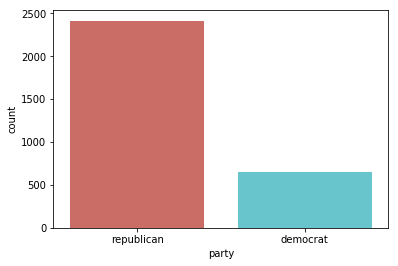

In [743]:
sns.countplot(x='party', data=newTable, palette='hls')
plt.show()

In [744]:
countRep = len(newTable[newTable['party']=="republican"])
countDem = len(newTable[newTable['party']=="democrat"])
pctRep = countRep/(countRep+countDem)
print("The share of counties that had a majority of votes for the Republican candidate", pctRep*100)
pctDem = countDem/(countRep+countDem)
print("The share of counties that had a majority of votes for the Democratic candidate", pctDem*100)

The share of counties that had a majority of votes for the Republican candidate 78.83736120182887
The share of counties that had a majority of votes for the Democratic candidate 21.16263879817113


In [745]:
newTable.groupby('party').mean()

,candidatevotes,totalvotes,Percent; OCCUPANCY STATUS - Total housing units - Occupied housing units,Percent; VACANCY STATUS - Vacant housing units - For rent,Percent; RACE OF HOUSEHOLDER - Occupied housing units - One race - White,Percent; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over
party,,,,,,
democrat,43688.469136,79022.087894,87.140123,22.566821,77.442593,23.733951
republican,13123.037697,23254.844678,85.385294,20.223115,90.206711,25.145236


#### After binding by potential outcomes we see that:
* Where the Dmocratic candidate won, number of total votes in that county was nearly three times that of counties where the Republican candidate won
* Housing occupancy rates are higher in the counties where the Democrat candidate won
* Vacant housing units for rent are higher in counties where the Democrat candidate won
* Share of households that identify as "white" made of on average 90% in counties where the Republican candidate won
* Counties that favored the Republican candidate also head a higher proportion of households headed by senior citizens than the ones won by the Democratic candidate

In [746]:
newTable.groupby('state').mean()

,candidatevotes,totalvotes,Percent; OCCUPANCY STATUS - Total housing units - Occupied housing units,Percent; VACANCY STATUS - Vacant housing units - For rent,Percent; RACE OF HOUSEHOLDER - Occupied housing units - One race - White,Percent; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over
state,,,,,,
Alabama,14568.164179,24963.447761,86.082090,22.737313,71.840299,23.798507
Arizona,54429.733333,102274.200000,78.073333,17.026667,76.313333,25.446667
Arkansas,6911.000000,12290.413333,86.440000,21.352000,83.210667,26.104000
California,109751.534483,189066.482759,87.446552,21.950000,79.274138,22.077586
Colorado,15580.047619,27640.714286,78.358730,18.012698,90.733333,19.866667
Connecticut,102001.875000,182440.625000,93.150000,26.125000,89.325000,21.462500
Delaware,62080.000000,109176.333333,85.133333,26.666667,79.033333,22.800000
Florida,50968.469697,90194.590909,83.465152,20.115152,84.877273,28.090909
Georgia,10139.119497,18558.553030,87.651572,23.826415,72.479245,21.091195


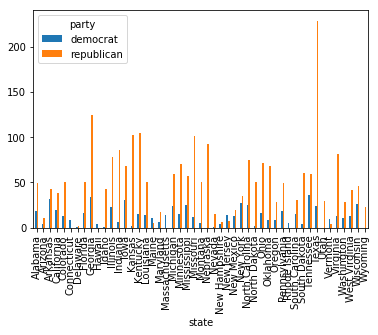

In [747]:
%matplotlib inline
pd.crosstab(newTable.state, newTable.party).plot(kind='bar')
my_dpi = 96
plt.figure(figsize=(1920/my_dpi, 960/my_dpi), dpi=my_dpi)


## Convert party to a binary output

In [769]:
cat_vars= ['party']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(newTable[var], prefix=var)
    data1=newTable.join(cat_list)
    newTable=data1

In [772]:
newTable.dtypes

county                                                                       object
state                                                                        object
candidate                                                                    object
party                                                                        object
candidatevotes                                                              float64
totalvotes                                                                  float64
Percent; OCCUPANCY STATUS - Total housing units - Occupied housing units    float64
Percent; VACANCY STATUS - Vacant housing units - For rent                   float64
Percent; RACE OF HOUSEHOLDER - Occupied housing units - One race - White    float64
Percent; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over    float64
party_democrat                                                                uint8
party_republican                                                            

In [775]:
cat_vars= ['party']
data_vars=newTable.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]

In [777]:
data_final=newTable[to_keep]
data_final

,county,state,candidate,candidatevotes,totalvotes,Percent; OCCUPANCY STATUS - Total housing units - Occupied housing units,Percent; VACANCY STATUS - Vacant housing units - For rent,Percent; RACE OF HOUSEHOLDER - Occupied housing units - One race - White,Percent; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over,party_democrat,party_republican
0,Autauga,Alabama,George W. Bush,11993.0,17208.0,90.6,31.8,82.0,18.6,0,1
1,Baldwin,Alabama,George W. Bush,40872.0,56480.0,74.5,17.1,89.5,25.2,0,1
2,Barbour,Alabama,Al Gore,5188.0,10395.0,83.5,18.5,56.3,25.3,1,0
3,Bibb,Alabama,George W. Bush,4273.0,7101.0,88.9,16.2,81.3,21.8,0,1
4,Blount,Alabama,George W. Bush,12667.0,17973.0,91.1,21.7,96.2,22.2,0,1
5,Bullock,Alabama,Al Gore,3395.0,4904.0,84.3,11.1,27.0,26.2,1,0
6,Butler,Alabama,George W. Bush,4127.0,7803.0,84.3,17.3,62.2,27.8,0,1
7,Calhoun,Alabama,George W. Bush,22306.0,38909.0,88.3,34.6,80.6,23.6,0,1
8,Chambers,Alabama,George W. Bush,6037.0,11834.0,89.3,28.5,65.1,26.7,0,1
9,Cherokee,Alabama,George W. Bush,4154.0,7823.0,69.3,5.3,93.4,25.2,0,1


In [759]:
#finTable.party[finTable.party =='republican'] =0
#finTable.party[finTable.party =='democrat'] =1

C:\Users\timsr\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\timsr\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [760]:
finTable.dtypes

party                                                                        object
Percent; OCCUPANCY STATUS - Total housing units - Occupied housing units    float64
Percent; VACANCY STATUS - Vacant housing units - For rent                   float64
Percent; RACE OF HOUSEHOLDER - Occupied housing units - One race - White    float64
Percent; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over    float64
dtype: object

In [761]:
#finTable['party'].astype(float)

0       0.0
1       0.0
2       1.0
3       0.0
4       0.0
5       1.0
6       0.0
7       0.0
8       0.0
9       0.0
10      0.0
11      1.0
12      0.0
13      0.0
14      0.0
15      0.0
16      1.0
17      1.0
18      0.0
19      0.0
20      0.0
21      0.0
22      0.0
23      1.0
24      0.0
25      0.0
26      0.0
27      0.0
28      0.0
29      0.0
       ... 
3032    0.0
3033    0.0
3034    0.0
3035    0.0
3036    0.0
3037    0.0
3038    0.0
3039    0.0
3040    0.0
3041    0.0
3042    0.0
3043    0.0
3044    0.0
3045    0.0
3046    0.0
3047    0.0
3048    0.0
3049    0.0
3050    0.0
3051    0.0
3052    0.0
3053    0.0
3054    0.0
3055    0.0
3056    0.0
3057    0.0
3058    0.0
3059    0.0
3060    0.0
3061    0.0
Name: party, Length: 3062, dtype: float64

In [785]:
finTable = data_final[['party_republican',
                     'Percent; OCCUPANCY STATUS - Total housing units - Occupied housing units',
                     'Percent; VACANCY STATUS - Vacant housing units - For rent',
                     'Percent; RACE OF HOUSEHOLDER - Occupied housing units - One race - White',
                     'Percent; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over'
                    ]]

In [786]:
finTable

,party_republican,Percent; OCCUPANCY STATUS - Total housing units - Occupied housing units,Percent; VACANCY STATUS - Vacant housing units - For rent,Percent; RACE OF HOUSEHOLDER - Occupied housing units - One race - White,Percent; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over
0,1,90.6,31.8,82.0,18.6
1,1,74.5,17.1,89.5,25.2
2,0,83.5,18.5,56.3,25.3
3,1,88.9,16.2,81.3,21.8
4,1,91.1,21.7,96.2,22.2
5,0,84.3,11.1,27.0,26.2
6,1,84.3,17.3,62.2,27.8
7,1,88.3,34.6,80.6,23.6
8,1,89.3,28.5,65.1,26.7
9,1,69.3,5.3,93.4,25.2


In [763]:
!pip install imblearn

You are using pip version 9.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [787]:
X = finTable.loc[:, finTable.columns != 'party_republican']
y = finTable.loc[:, finTable.columns == 'party_republican']

from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['party_republican'])

print("length of oversampled data is ",len(os_data_X))
print("Number of counties democrats won in oversampled data",len(os_data_y[os_data_y['party_republican']==0]))
print("Number of republican won counties",len(os_data_y[os_data_y['party_republican']==1]))

length of oversampled data is  3376
Number of counties democrats won in oversampled data 1688
Number of republican won counties 1688


C:\Users\timsr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Recursive Feature Elimination
#### RFE is based on the idea to repeatedly construct a model and choose either the best or the worst performing feature, setting the feature asside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. The goal of RFE is to select features by recursively considering smaller and smaller sets of features.

In [781]:
#dataFinalVars = finTable.columns.values.tolist()
#y=['party']
#X = [i for i in dataFinalVars if i not in y]

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

#logreg = LogisticRegression()
#rfe = RFE(logreg, 20)
#rfe = rfe.fit(os_data_X, os_data_y.values.ravel())


In [782]:
#cols=['Percent; OCCUPANCY STATUS - Total housing units - Occupied housing units',
#                     'Percent; VACANCY STATUS - Vacant housing units - For rent',
#                     'Percent; RACE OF HOUSEHOLDER - Occupied housing units - One race - White',
#                     'Percent; AGE OF HOUSEHOLDER - Occupied housing units - 65 years and over']
#X=os_data_X[cols]
#y=os_data_y['party']

In [788]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 9.716082
         Iterations 6
                                                     Results: Logit
Model:                                 Logit                              Pseudo R-squared:                   -50.830   
Dependent Variable:                    party_republican                   AIC:                                59509.2835
Date:                                  2019-05-13 14:33                   BIC:                                59533.3908
No. Observations:                      3062                               Log-Likelihood:                     -29751.   
Df Model:                              3                                  LL-Null:                            -574.01   
Df Residuals:                          3058                               LLR p-value:                        1.0000    
Converged:                             1.0000                             Scale:                        

In [789]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

C:\Users\timsr\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\timsr\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [790]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.82


In [791]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[ 45 148]
 [ 15 711]]
